In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import layers

EMB = 1024
TOKEN_FEATURES = 15
FEATURES = 30
CLASSES = 43

In [2]:
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()



metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}


class ThresholdLayer(layers.Layer):
  def __init__(self, **kwargs):
    super(ThresholdLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.kernel = self.add_weight(name="threshold", shape=(1,), initializer="uniform",
                                  trainable=True)
    super(ThresholdLayer, self).build(input_shape)

  def call(self, x):
    return keras.backend.sigmoid(100 * (x - self.kernel))

  def compute_output_shape(self, input_shape):
    return input_shape

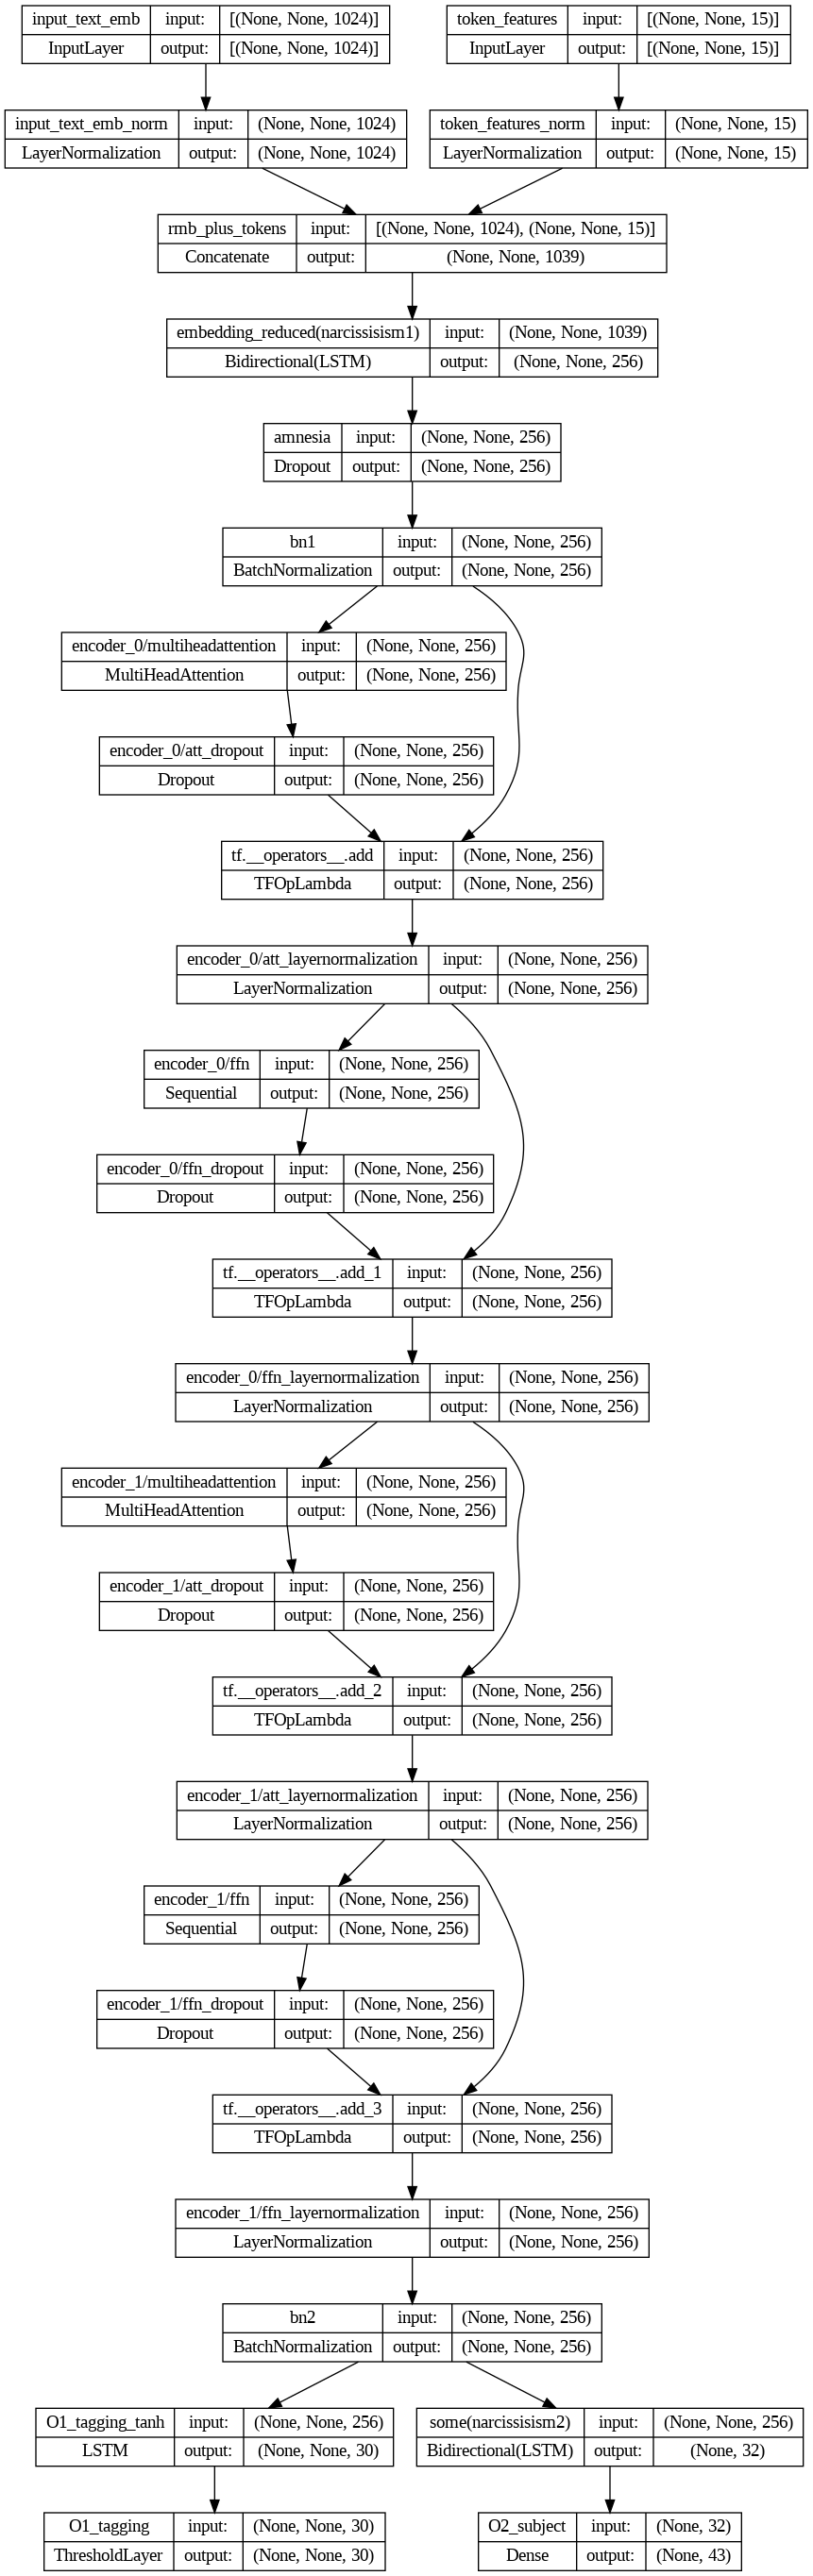

In [3]:
#------------------
def bert_module(query, key, value, i, height, key_dim_base):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=key_dim_base // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)

  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(attention_output)
  
  attention_output = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_{i}/att_layernormalization")(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output



def make_att_model_03(name='make_att_model_03'):
  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  input_text_emb_n = layers.LayerNormalization(epsilon=1e-6, name="input_text_emb_norm")(input_text_emb)

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.LayerNormalization(epsilon=1e-6, name="token_features_norm")(token_features)

  _lstm_height = 128
  _out = layers.concatenate([input_text_emb_n, token_features_n], axis=-1, name='rmb_plus_tokens')
  _out = layers.Bidirectional(layers.LSTM(_lstm_height, return_sequences=True, name='narcissisism1', activation='tanh'),
                              name='embedding_reduced')(_out)
  _out = layers.Dropout(0.2, name='amnesia')(_out)
  _out = layers.BatchNormalization(name="bn1")(_out)

  _bert = _out
  for i in range(2):
    _bert = bert_module(_bert, _bert, _bert, i, height=_lstm_height * 2, key_dim_base=_lstm_height * 2)

  _bert = layers.BatchNormalization(name="bn2")(_bert)

  _out = _bert
  _out = layers.LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)

  _out1 = ThresholdLayer(name='O1_tagging')(_out)

  _out = layers.Bidirectional(layers.LSTM(16, return_sequences=False, name='narcissisism2', activation='tanh'),
                              name='some')(_bert)

  _out2 = layers.Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model

a_model = make_att_model_03()

dot_img_file = f'/tmp/model_{a_model.name}.png'
tf.keras.utils.plot_model(a_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
a_model.summary()

Model: "make_att_model_03"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text_emb (InputLayer)    [(None, None, 1024)  0           []                               
                                ]                                                                 
                                                                                                  
 token_features (InputLayer)    [(None, None, 15)]   0           []                               
                                                                                                  
 input_text_emb_norm (LayerNorm  (None, None, 1024)  2048        ['input_text_emb[0][0]']         
 alization)                                                                                       
                                                                                  